In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
import os
import glob
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm
from scipy import interpolate
import itertools

from utils_analysis import *
from PIL import Image

In [2]:
plt.rcParams["font.family"] = "Arial" 
#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [3]:
fps = 29.93

In [4]:
s_f = [156, 554]
v_i = [2, 4]
#s_f = [1, 156, 554]
#v_i = [1, 2, 4]

In [5]:
preproceeed_data_path = "../dataset/Nakano_etal_2010/preprocessed_data"

In [6]:
mds_dist = np.load("../results/mds_dist_N2010_dim32.npz", allow_pickle=True)

In [7]:
mds_dist_dict = mds_dist["mds_dist"].item()
mds_dist_min_dict = mds_dist["mds_dist_min"].item()

In [8]:
training_methods = ["dino", "supervised"] 
depth_list = [4, 8, 12]
num_models = 6

In [9]:
mds_dist_dict.keys()

dict_keys(['dino', 'supervised', 'subj', 'gbvs', 'dino_deit_small16', 'supervised_deit_small16'])

In [10]:
best_head_indices_dict = {}
num_top = 5
for tm in training_methods:
    best_head_indices_dict[tm] = {}
    for depth in depth_list:
        model_mds_dist = mds_dist_dict[tm][str(depth)]
        #if depth == 12:
        #    model_mds_dist = np.concatenate([model_mds_dist, mds_dist_dict[f'{tm}_deit_small16'][None, :, :]])
        num_models = len(model_mds_dist)
        best_head_indices = np.zeros((num_models, num_top, 3))
        for i in range(num_models):
            model_mds_dist_min = np.sort(model_mds_dist[i].flatten())[:num_top]
            for j in range(num_top):
                model_indices = np.argwhere(model_mds_dist == model_mds_dist_min[j])
                best_head_indices[i, j] = model_indices[0]
        best_head_indices_dict[tm][str(depth)] = best_head_indices

In [11]:
vit_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/vit_gaze_pos.npz", allow_pickle=True)
vit_official_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/vit_official_gaze_pos.npz", allow_pickle=True)
gbvs_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/gbvs_gaze_pos.npz", allow_pickle=True)

In [12]:
gbvs_gaze_pos["labels"]#.files

array(['All', 'Intensity', 'Orientation', 'Contrast', 'Flicker', 'Motion',
       'DKL_Color'], dtype='<U11')

In [13]:
subj_gazepos_data = np.load("../dataset/Nakano_etal_2010/preprocessed_data/goodsubj_gaze_pos.npz", allow_pickle=True)
gazepos_goodsubj = subj_gazepos_data['gaze_data_goodsubj']
gr_goodsubj = subj_gazepos_data['gr_goodsubj']
group_name = subj_gazepos_data['group_name']

In [14]:
patch_size = 16
group_name = ["TD adults/children", "ASD adults/children", 
              "DINO ViT-12", "SL ViT-12"]#, "GBVS"]
#group_name = ["TD adults/children", "ASD adults/children", 
#              "DINO ViT-8", "DINO ViT-12", "SL ViT-8", "SL ViT-12"]#, "GBVS"]
gr_indices = [0, 1, 4, 3]
num_gbvs = 7

In [15]:
frame_indices = [300, 692]# 83 690]#, 950]

In [16]:
cmap_cb = sns.color_palette("colorblind")
cmap_bt = sns.color_palette("bright")
cmap = sns.color_palette("tab10")
#cmap = mpl.colormaps.get_cmap('tab10')

subj_labels = ["TD adults", "TD children", "ASD adults", "ASD children"]
subj_ecolors = [cmap[3], cmap_cb[8], cmap[1], cmap[4]]
subj_fcolors = [cmap[3], cmap_cb[8], "white", "white"]
subj_markers = ["o", "^", "o", "^"]
model_labels = [["DINO ViT-4", "DINO ViT-8", "DINO ViT-12"], ["SL ViT-4", "SL ViT-8", "SL ViT-12"]]
model_colors = [[cmap_cb[9] for j in range(3)], [cmap_cb[2] for j in range(3)], [cmap_cb[7]]]
model_markers = ["P", "s", "D"]

In [17]:
# subj data
frame_reindices = [np.floor(frame_idx * 3883 / 2327).astype(int) for frame_idx in frame_indices]
#frame_reindices = [np.round(frame_idx * 3883 / 2327).astype(int) for frame_idx in frame_indices]
gazepos_subj_slice = [gazepos_goodsubj[:, frame_reidx] for frame_reidx in frame_reindices]
#frame_reindices = [np.round((frame_idx + np.array([0,1])) * 3883 / 2327).astype(int) for frame_idx in frame_indices]
#gazepos_subj_slice = [np.nanmedian(gazepos_goodsubj[:, frame_reidx[0]:frame_reidx[1]], axis=1) for frame_reidx in frame_reindices]

#blur_imgs = [Image.open("../dataset/Nakano_etal_2010/video_stimuli/frames/frame{0:04}.png".format(frame_idx)) for frame_idx in frame_indices]
blur_imgs = [Image.open("../figures/masked_frames/frame{0:04}_masked.png".format(frame_idx)) for frame_idx in frame_indices]

In [18]:
best_gaze_pos = {}
for img_idx, frame_idx in enumerate(frame_indices):
    best_gaze_pos[str(frame_idx)] = {}
    for tm in training_methods:
        best_gaze_pos[str(frame_idx)][tm] = {}
        for depth in depth_list:
            gaze_pos_depth = vit_gaze_pos[tm].item()[str(depth)]
            best_head_indices = best_head_indices_dict[tm][str(depth)]
            num_models, num_top, _ = best_head_indices.shape
            gaze_pos_tmp = np.zeros((num_models, num_top, 2))
            for i in range(num_models):
                for j in range(num_top):
                    idx = best_head_indices[i, j].astype(int)
                    if i < 6:
                        gaze_pos_tmp[i, j] = gaze_pos_depth[idx[0], idx[1], idx[2], frame_idx]
                    else:
                        gaze_pos_tmp[i, j] = vit_official_gaze_pos[f"{tm}_deit_small16"][idx[1], idx[2], frame_idx]

            best_gaze_pos[str(frame_idx)][tm][str(depth)] = gaze_pos_tmp

In [19]:
gaze_pos_all_dict = {}
sigma = patch_size/6
for img_idx, frame_idx in enumerate(frame_indices):
    gaze_pos_all_dict[str(img_idx)] = {}
    for gn in group_name:
        gaze_pos_all_dict[str(img_idx)][gn] = {}
        gaze_pos_all_dict[str(img_idx)][gn]["x"] = []
        gaze_pos_all_dict[str(img_idx)][gn]["y"] = []
        gaze_pos_all_dict[str(img_idx)][gn]["ec"] = []
        gaze_pos_all_dict[str(img_idx)][gn]["fc"] = []
        gaze_pos_all_dict[str(img_idx)][gn]["m"] = []
    for j, gn in enumerate(group_name):
        x, y, ec, fc, m, zo = [], [], [], [], [], []
        if j < 2:
            for i, gr_idx in enumerate(gr_indices[j*2:(j+1)*2]):
                gr_slice = gr_goodsubj == gr_idx
                x.append(gazepos_subj_slice[img_idx][gr_slice,0])
                y.append(gazepos_subj_slice[img_idx][gr_slice,1])
                ec.append([subj_ecolors[j*2+i]] * np.sum(gr_slice))
                fc.append([subj_fcolors[j*2+i]] * np.sum(gr_slice))
                m.append([subj_markers[j*2+i]] * np.sum(gr_slice))
                zo.append([1] * np.sum(gr_slice))
        else:
            tm_, depth = gn.split("-")
            if tm_ == "SL ViT":
                tm = "supervised"
                ii = 1
            else:
                tm = "dino"
                ii = 0
            jj = int(depth) // 4 - 1
            x, y, ec, fc, m, zo = [], [], [], [], [], []
            best_gaze_pos_depth = best_gaze_pos[str(frame_idx)][tm][str(depth)]
            num_models, num_top, _ = best_gaze_pos_depth.shape
            best_gaze_pos_depth += np.random.randn(num_models, num_top, 2) * sigma
            for k in range(num_models):
                for l in range(num_top):
                    x.append(best_gaze_pos_depth[k, l, 0])
                    y.append(best_gaze_pos_depth[k, l, 1])
                    """
                    if l == 0:
                        ec.append(["white"])
                        if k < 6:
                            zo.append([2])
                        else:
                            zo.append([3])                                    
                    else:
                    """
                    ec.append([model_colors[ii][jj]])
                    zo.append([1])
                    fc.append([model_colors[ii][jj]])
                    if k < 6:
                        m.append([model_markers[jj]])
                    else:
                        m.append(["P"])   
        gaze_pos_all_dict[str(img_idx)][gn]["x"] = np.hstack(x)
        gaze_pos_all_dict[str(img_idx)][gn]["y"] = np.hstack(y)
        gaze_pos_all_dict[str(img_idx)][gn]["ec"] = list(itertools.chain.from_iterable(ec))
        gaze_pos_all_dict[str(img_idx)][gn]["fc"] = list(itertools.chain.from_iterable(fc))
        gaze_pos_all_dict[str(img_idx)][gn]["m"] = list(itertools.chain.from_iterable(m))
        gaze_pos_all_dict[str(img_idx)][gn]["zo"] = list(itertools.chain.from_iterable(zo))

In [20]:
alpha = 0.9

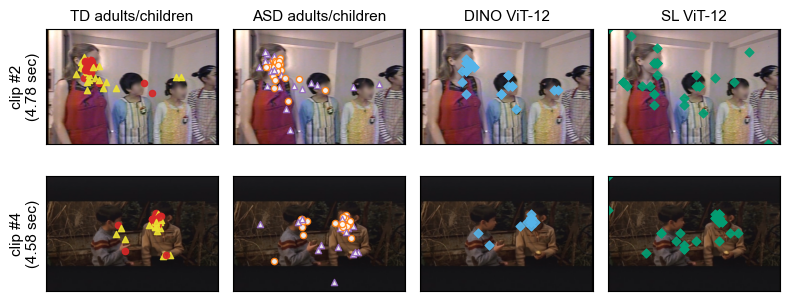

In [21]:
fig, axes = plt.subplots(len(frame_indices), len(group_name), figsize=(8, 5), tight_layout=True)
for img_idx, frame_idx in enumerate(frame_indices):
    for j, gn in enumerate(group_name):
        x = gaze_pos_all_dict[str(img_idx)][gn]["x"]
        y = gaze_pos_all_dict[str(img_idx)][gn]["y"]
        ec = gaze_pos_all_dict[str(img_idx)][gn]["ec"]
        fc = gaze_pos_all_dict[str(img_idx)][gn]["fc"]
        m = gaze_pos_all_dict[str(img_idx)][gn]["m"]
        zo = gaze_pos_all_dict[str(img_idx)][gn]["zo"]
        shuffle_index = np.random.permutation(np.arange(len(x)))
        for i in shuffle_index:
            axes[img_idx, j].scatter(x[i], y[i], ec=ec[i], fc=fc[i], marker=m[i], 
                                     s=20, alpha=alpha, rasterized=False, zorder=zo[i])
        axes[img_idx, j].imshow(blur_imgs[img_idx])
        axes[0, j].set_title(gn, fontsize=11)
        axes[img_idx, j].set_xticks([])
        axes[img_idx, j].set_yticks([])
for i in range(2):
    axes[i, 0].set_ylabel(f"clip #{v_i[i]}\n({(frame_indices[i] - s_f[i] - 1)/fps:.2f} sec)", fontsize=11)
#axes[3, 0].set_ylabel("clip #6")
#fig.savefig("../figures/gaze_points_examples.png", bbox_inches='tight', dpi=300)
fig.savefig("../figures/gaze_points_examples.svg", bbox_inches='tight', dpi=200)

In [22]:
"""
for i in range(4):
    plt.scatter(0, 0, ec=subj_ecolors[i], fc=subj_fcolors[i], marker=subj_markers[i], alpha=alpha, label=subj_labels[i])
for i in range(2):
    for j in range(3):
        if j > 1:
            plt.scatter(0, 0, ec=model_fcolors[i][j], fc=model_fcolors[i][j], marker=model_markers[j], alpha=alpha, label=model_labels[i][j]+" (Best1/2-5)")
            plt.scatter(0, 0, ec="white", fc=model_fcolors[i][j], marker=model_markers[j], alpha=alpha, label=" ")
    if i == 0:
        plt.scatter(0, 0, ec=model_fcolors[i][j], fc=model_fcolors[i][j], marker="P", alpha=alpha, label="Official ViT-12 (DINO/SL)")
    else:
        plt.scatter(0, 0, ec=model_fcolors[i][j], fc=model_fcolors[i][j], marker="P", alpha=alpha, label=" ")        
plt.scatter(0, 0, ec="k", fc="tab:gray", marker="v", alpha=alpha, label="GBVS (All/single feature ch.)")
plt.scatter(0, 0, ec="white", fc="tab:gray", marker="v", alpha=alpha, label=" ")
l = plt.legend(ncol=6, facecolor="gainsboro", scatterpoints=1,scatteryoffsets=[0], columnspacing=0.1, labelspacing=0.5, handletextpad=0)
for t in l.get_texts(): 
    t.set_va('center_baseline')
plt.savefig("../figures/gaze_points_examples_legend.svg", bbox_inches='tight', dpi=300)
"""

'\nfor i in range(4):\n    plt.scatter(0, 0, ec=subj_ecolors[i], fc=subj_fcolors[i], marker=subj_markers[i], alpha=alpha, label=subj_labels[i])\nfor i in range(2):\n    for j in range(3):\n        if j > 1:\n            plt.scatter(0, 0, ec=model_fcolors[i][j], fc=model_fcolors[i][j], marker=model_markers[j], alpha=alpha, label=model_labels[i][j]+" (Best1/2-5)")\n            plt.scatter(0, 0, ec="white", fc=model_fcolors[i][j], marker=model_markers[j], alpha=alpha, label=" ")\n    if i == 0:\n        plt.scatter(0, 0, ec=model_fcolors[i][j], fc=model_fcolors[i][j], marker="P", alpha=alpha, label="Official ViT-12 (DINO/SL)")\n    else:\n        plt.scatter(0, 0, ec=model_fcolors[i][j], fc=model_fcolors[i][j], marker="P", alpha=alpha, label=" ")        \nplt.scatter(0, 0, ec="k", fc="tab:gray", marker="v", alpha=alpha, label="GBVS (All/single feature ch.)")\nplt.scatter(0, 0, ec="white", fc="tab:gray", marker="v", alpha=alpha, label=" ")\nl = plt.legend(ncol=6, facecolor="gainsboro", sca